In [1]:
from tensorflow.keras.preprocessing.image import(
    ImageDataGenerator,
    img_to_array,
    load_img
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import(
    AveragePooling2D,
    Dropout,
    Flatten,
    Dense,
    Input
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np
import os

import cv2

In [2]:
LR = 1e-4 
EPOCHS = 20
BS = 32

# Put the Dataset Path Here
DATA_PATH = "./dataset"
Class = ["with_mask", "without_mask"]

In [3]:
#IMAGE & LABEL Gathering
imgs = []
labels = []

for cl in Class:
    path = os.path.join(DATA_PATH, cl)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        imgs.append(image)
        labels.append(cl)
print(len(labels))
print(imgs[0][0:2])

1376
[[[-0.5529412  -0.5058824  -0.7254902 ]
  [-0.6392157  -0.5764706  -0.7647059 ]
  [-0.654902   -0.58431375 -0.7490196 ]
  ...
  [-0.6784314  -0.654902   -0.8039216 ]
  [-0.75686276 -0.7254902  -0.9372549 ]
  [-0.7176471  -0.6784314  -0.85882354]]

 [[-0.6        -0.5529412  -0.75686276]
  [-0.64705884 -0.58431375 -0.77254903]
  [-0.6392157  -0.5686275  -0.73333335]
  ...
  [-0.49019605 -0.4588235  -0.5764706 ]
  [-0.8039216  -0.7647059  -0.94509804]
  [-0.70980394 -0.64705884 -0.827451  ]]]


In [4]:
# Label encoding and spliting the dataset into training and testing.
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(imgs)
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [5]:
# Image Augmentation for increasing dataset count.
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [6]:
# Using MobileNetV2 as Base Network for this model with 224 x 224 x 3 as input shape.
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

9420800/9406464 [==============================] - 258s 27us/step


In [7]:
# Appending the own custom Head Network with 1 Average Pooling Layer, Flatten, 2 Dense layers with 0.5 Dropout, Relu Activation for Dense Layers and Softmax Activation for Output Layer.
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [8]:
# Creating Optimizer of Adam with 1e-4 LR and complie the model after that.
opt = Adam(lr=LR, decay=LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

C:\Users\user\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [9]:
# Train a model with train partition for training and test partition for validation
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch = len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps= len(testX) // BS,
    epochs = EPOCHS
)

Epoch 1/20
34/34 [==============================] - 92s 2s/step - loss: 0.5106 - accuracy: 0.8081 - val_loss: 0.2174 - val_accuracy: 0.9891
Epoch 2/20
34/34 [==============================] - 72s 2s/step - loss: 0.1894 - accuracy: 0.9747 - val_loss: 0.0937 - val_accuracy: 0.9964
Epoch 3/20
34/34 [==============================] - 70s 2s/step - loss: 0.1126 - accuracy: 0.9822 - val_loss: 0.0573 - val_accuracy: 0.9964
Epoch 4/20
34/34 [==============================] - 73s 2s/step - loss: 0.0788 - accuracy: 0.9841 - val_loss: 0.0416 - val_accuracy: 0.9964
Epoch 5/20
34/34 [==============================] - 68s 2s/step - loss: 0.0601 - accuracy: 0.9888 - val_loss: 0.0334 - val_accuracy: 1.0000
Epoch 6/20
34/34 [==============================] - 75s 2s/step - loss: 0.0437 - accuracy: 0.9944 - val_loss: 0.0273 - val_accuracy: 0.9964
Epoch 7/20
34/34 [==============================] - 74s 2s/step - loss: 0.0489 - accuracy: 0.9897 - val_loss: 0.0234 - val_accuracy: 1.0000
Epoch 8/20
34/34 [==

In [11]:
model.load_weights("mask_detector.model")

In [12]:
#Predicting the Whole Test Partition for performance measure. 
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

In [ ]:
#Ploting a confusion metric with Precision and Recall value.
print(classification_report(testY.argmax(axis=1), predIdxs, target_names = lb.classes_))

In [13]:
#Saving a Model.
model.save("mask_detector.model", save_format="h5")

C:\Users\user\anaconda3\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


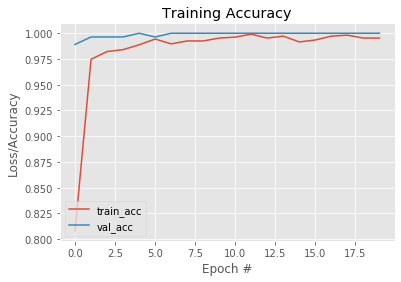

In [15]:
# Plotting and saving the Accuracy graph of training and validation. 
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig("train_acc.png")

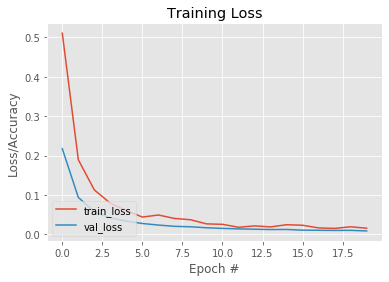

In [16]:
#Plotting and saving the Loss graph of training and validation. 
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig("train_loss.png")

In [21]:
# predicting custom image
try_img = load_img("try\\me_without.jpg", target_size=(224,224))
try_img = img_to_array(try_img)
image = preprocess_input(try_img)
pred = model.predict(image[np.newaxis, :, : ,:])
print(pred,Class[np.argmax(pred)])

[[5.3704614e-05 9.9994624e-01]] without_mask
